In [1]:
import os
import re
import numpy as np
import numpy
genecode_genes = set(os.listdir("experiment_blood"))
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
import random
import bisect
import math
import json
import sys
from __future__ import print_function

In [2]:
def in_ipynb():
    try:
        get_ipython()
        return True
    except NameError:
        return False

In [3]:
if in_ipynb():
    from matplotlib import pyplot as plt

In [4]:
# Should be at least 10**4, preferably 10**6
r2_simulation_size = 10**6

In [5]:
print("Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`\n"\
      "tissue can be any of: blood, muscle.\n"\
      "genes can be any of: TNNI1, batra, nakamori, all\n"\
      "simulation runs can be 10\n"\
      "top_k_genes can be 500\n"\
      "PLSR_dimensions can be 2"
     )
if not in_ipynb():
    tissue_arg = sys.argv[1]
    print("tissue: {}".format(tissue_arg))
    gene_arg = sys.argv[2]
    print("gene: {}".format(gene_arg))
    simulation_arg = int(sys.argv[3])
    print("simulation_arg: {}".format(simulation_arg))
    top_genes_arg = int(sys.argv[4])
    print("top_genes_arg: {}".format(top_genes_arg))
    PLSR_arg = int(sys.argv[5])
    print("PLSR_arg: {}".format(PLSR_arg))

Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`
tissue can be any of: blood, muscle.
genes can be any of: TNNI1, batra, nakamori, all
simulation runs can be 10
top_k_genes can be 500
PLSR_dimensions can be 2


In [6]:
def load_genes(filename):
    genes = set()
    repeated = set()
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if line in genes:
                repeated.add(line)
            genes.add(line)
    failed = genes.difference(genecode_genes)
    if repeated:
        print("These genes appear more than once: {}".format([g for g in repeated]))
    if failed:
        print("Couldn't identify the following genes: {}".format([g for g in failed]))
    return genes.intersection(genecode_genes)

In [7]:
nakamori_genes = load_genes("nakamori_genes.txt")

These genes appear more than once: ['LDB3', 'PHKA1', 'DMD']


In [8]:
nakamori_genes

{'ABLIM2',
 'ALPK3',
 'ANK2',
 'ARFGAP2',
 'ATP2A1',
 'ATP2A2',
 'BIN1',
 'CACNA1S',
 'CAMK2B',
 'CAPN3',
 'CAPZB',
 'CLCN1',
 'COPZ2',
 'DMD',
 'DTNA',
 'FHOD1',
 'GFPT1',
 'IMPDH2',
 'INSR',
 'KIF13A',
 'LDB3',
 'MBNL1',
 'MBNL2',
 'MLF1',
 'NFIX',
 'NRAP',
 'OPA1',
 'PDLIM3',
 'PHKA1',
 'RYR1',
 'SOS1',
 'TBC1D15',
 'TTN',
 'TXNL4A',
 'UBE2D3',
 'USP25',
 'VEGFA',
 'VPS39'}

In [9]:
len(nakamori_genes)

38

In [10]:
for gene in nakamori_genes:
    print(gene, end=" ")

DTNA FHOD1 RYR1 MBNL1 MBNL2 ARFGAP2 TBC1D15 GFPT1 NFIX CAPZB CAPN3 UBE2D3 USP25 VPS39 SOS1 ANK2 LDB3 BIN1 TXNL4A CACNA1S DMD OPA1 ATP2A1 IMPDH2 NRAP ABLIM2 PDLIM3 ATP2A2 VEGFA TTN MLF1 ALPK3 KIF13A CLCN1 PHKA1 COPZ2 INSR CAMK2B 

In [11]:
# Genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4224598/
batra_genes = load_genes("batra_genes.txt")

These genes appear more than once: ['TPM1', 'DNAJB6', 'LDB3', 'NDUFB10', 'ASPH', 'PDLIM5', 'CHRNA1', 'PCM1', 'SNX1', 'TNNI1', 'TPM3', 'TPM2', 'TTYH3', 'SMIM3', 'MEF2B', 'IDH3A', 'CEBPA']


In [12]:
len(batra_genes)

80

In [13]:
for batra_gene in batra_genes:
    print(batra_gene, end=" ")

ABCA1 MEF2C PDLIM5 KIF1B CHRNA1 KCNK7 MDN1 SPATS2L TPM3 ILF3 MBNL2 SLC25A36 CLDND1 DES TPM1 OSBPL1A TPM2 HDAC11 AP1G1 CELF1 FASTK LDB3 NDUFB10 NR2F1 PCMT1 PCM1 DAPK2 RTN2 RIN1 MORC3 PLIN2 BRSK2 CIRBP TJP2 TTYH3 PIK3C2B PFKFB2 PEBP4 ARHGEF7 DST KRBA1 MEF2D MGP GPS1 MTCH1 SNX1 NUP43 TMEM38B SAMD4A EZR TBL2 SMIM3 CDC42 MYH6 MEF2B IDH3A CEBPA CACNA1G ALG3 SPEG DNAJB6 SPTB AMHR2 AGL ASPH TNNI1 DVL3 ATP5E PDLIM2 BRWD1 CACNB1 LMNA COPS4 KDELR1 SETD3 LAMP2 PCBD2 TGFBI U2SURP RAB24 

In [14]:
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

In [15]:
blood_meta, muscle_meta = load_metadata()

In [29]:
def produce_data(meta, gene_names, experiment):
    IDs = meta.IDs
    probe_data = []
    probe_IDs = []
    for gene in gene_names:        
        with open(os.path.join(experiment, gene)) as f:
            for i, line in enumerate(f):
                line = line.rstrip().split()
                if i == 0:
                    prefix = "patient_"
                    our_IDs = [elem[len(prefix):] for elem in line if re.match(prefix, elem)]
                    try:
                        assert IDs == our_IDs
                    except AssertionError:
                        print(gene)
                    headers = {header: i for i, header in enumerate(line)}
                    patient_data = {header[len(prefix):]: i for i, header in enumerate(line) if re.match(prefix, header)}
                    def write_signature(line):
                        signature = []
                        for elem in ["gene_name", "probeset_id", "seq5to3plus", "chrom", "strand", "genocode_left", "genecode_right"]:
                            signature.append(line[headers[elem]])
                        return "_".join(signature)
                else:
                    probe_ID = write_signature(line)
                    rv = []
                    for patient_id in IDs:
                        rv.append(float(line[patient_data[patient_id]]))
                    probe_data.append(rv)
                    probe_IDs.append(probe_ID)
    probe_data = numpy.array(probe_data)
    return probe_data, probe_IDs

In [30]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[just_indices, :]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[0]):
        gene_r, _ = pearsonr(allele, data[i])
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[1]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[:, training_indices], data[:, test_indices]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

In [31]:
def filter_extremes(value, lowermost, uppermost):
    """If a value is lower or higher than lowermost or uppermost, return lowermost or uppermost. Otherwise, return value.
    """
    if value < lowermost:
        return lowermost
    if value > uppermost:
        return uppermost
    return value

In [180]:
def simulation_step_PLSR(probeset_data, metadata, training_size, no_probes, n_components):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [filter_extremes(i[0], min(repeat_length_training), max(repeat_length_training)) for i in results]

    return repeat_length_testing, results

In [219]:
def simulation_step_LASSO(probeset_data, metadata, training_size, no_probes, n_components):
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    lasso = sklearn.linear_model.Lasso(alpha=n_components)
    
    lasso.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = list(lasso.predict(testing_set.transpose()))
    
    results = [filter_extremes(i, min(repeat_length_training), max(repeat_length_training)) for i in results]

    return repeat_length_testing, results

In [216]:
def simulation_step_LinearRegression(probeset_data, metadata, training_size, no_probes, n_components):
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    model = sklearn.linear_model.LinearRegression()
    
    model.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = model.predict(testing_set.transpose())
    results = [i for i in results.transpose()[0]]
    
    results = [filter_extremes(i, min(repeat_length_training), max(repeat_length_training)) for i in results]
    return repeat_length_testing, results

In [236]:
def simulation_step_GaussianProcess(probeset_data, metadata, training_size, no_probes, n_components):
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    model = sklearn.gaussian_process.GaussianProcessRegressor()
    
    model.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = model.predict(testing_set.transpose())
    results = [i for i in results.transpose()[0]]
    #results = [i for i in results.transpose()[0]]
    return repeat_length_testing, results

In [235]:
def simulation_step_RandomForestRegressor(probeset_data, metadata, training_size, no_probes, n_components):
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    model = sklearn.ensemble.RandomForestRegressor()
    
    model.fit(training_set.transpose(), repeat_length_training)
    
    results = list(model.predict(testing_set.transpose()))
    #results = [i for i in results.transpose()[0]]
    #results = [i for i in results.transpose()[0]]
    return repeat_length_testing, results

In [165]:
assert filter_extremes(0, 10, 20) == 10
assert filter_extremes(15, 10, 20) == 15
assert filter_extremes(25, 10, 20) == 20

In [166]:
metadata = {"muscle": muscle_meta, "blood": blood_meta}

In [167]:
metadata

{'blood': Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '141772399']...,
  CELs: ['111747589_B.CEL', '117440822_B.CEL', '124563003_B.CEL', '129523253_B.CEL', '141772399_B.CEL']...,
  modal_allele: [872, 297, 593, 408, 717]...,
  progenitor_allele: [600, 227, 301, 211, 320]...,
  MIRS: [4, 2, 4, 4, 2]...},
 'muscle': Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '159834720']...,
  CELs: ['111747589_M.CEL', '117440822_M.CEL', '124563003_M.CEL', '129523253_M.CEL', '159834720_MR.cel']...,
  modal_allele: [872, 297, 593, 408, 1035]...,
  progenitor_allele: [600, 227, 301, 211, 695]...,
  MIRS: [4, 2, 4, 4, 4]...}}

In [101]:
def load_data(name, genes, muscle_or_blood):
    meta = metadata[muscle_or_blood]
    path = "experiment_" + muscle_or_blood
    d, a = produce_data(meta, genes, path)
    data[muscle_or_blood][name] = d
    annot[muscle_or_blood][name] = a

In [102]:
gene_sets = {"nakamori": nakamori_genes, "batra": batra_genes, "TNNI1": ["TNNI1"], "all": genecode_genes}

In [103]:
gene_sets

{'TNNI1': ['TNNI1'],
 'all': {'MAP6D1',
  'C3orf70',
  'LCN1',
  'AARSD1',
  'RABL2A',
  'DHRS7B',
  'MAP3K4',
  'KLK2',
  'ZBED6',
  'CCDC102A',
  'DDX4',
  'RP11-691N7.6',
  'IL19',
  'MELK',
  'ITFG1',
  'HACD3',
  'SDCCAG3',
  'NUDT16',
  'TAF1B',
  'YWHAQ',
  'CRIM1',
  'CST11',
  'ZRSR2',
  'ZSCAN22',
  'ZNF782',
  'ISY1-RAB43',
  'WDSUB1',
  'AC135048.1',
  'ISM1',
  'GADL1',
  'SPSB1',
  'TBC1D32',
  'SEMA3G',
  'C19orf71',
  'DDHD1',
  'SNRK',
  'PLEKHM3',
  'TRMT5',
  'CSE1L',
  'ZNF2',
  'MTHFD2L',
  'SLC6A2',
  'OR2V2',
  'SI',
  'SIRT4',
  'AIM1L',
  'SLA',
  'NFE4',
  'IQCF6',
  'SPATA21',
  'PSMD7',
  'MRPL27',
  'DHX33',
  'MORN2',
  'MKL2',
  'RAB30',
  'OPRM1',
  'SLC9A3',
  'PRG2',
  'COMMD3',
  'TUSC5',
  'ALPK3',
  'ADSSL1',
  'PCMTD1',
  'KCNE2',
  'MYRFL',
  'SLC27A6',
  'SC5D',
  'EPN2',
  'FAM83F',
  'OR8B2',
  'CTSH',
  'DBT',
  'FAM153B',
  'PTPN22',
  'GANC',
  'IL24',
  'GNG7',
  'TOM1',
  'PLA2G3',
  'ARNTL2',
  'RMDN1',
  'CELF3',
  'RP11-468E2.2',
  'DCA

In [104]:
data = {"muscle": {}, "blood": {}}
annot = {"muscle": {}, "blood": {}}

In [105]:
for name, genes in gene_sets.items():
    for tissue in ["blood", "muscle"]:
        load_data(name, genes, tissue)

In [106]:
#simulation_step[key for key in ]

In [107]:
metadata

{'blood': Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '141772399']...,
  CELs: ['111747589_B.CEL', '117440822_B.CEL', '124563003_B.CEL', '129523253_B.CEL', '141772399_B.CEL']...,
  modal_allele: [872, 297, 593, 408, 717]...,
  progenitor_allele: [600, 227, 301, 211, 320]...,
  MIRS: [4, 2, 4, 4, 2]...},
 'muscle': Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '159834720']...,
  CELs: ['111747589_M.CEL', '117440822_M.CEL', '124563003_M.CEL', '129523253_M.CEL', '159834720_MR.cel']...,
  modal_allele: [872, 297, 593, 408, 1035]...,
  progenitor_allele: [600, 227, 301, 211, 695]...,
  MIRS: [4, 2, 4, 4, 4]...}}

In [108]:
training_size = int(len(metadata["muscle"].modal_allele)*0.7)

In [109]:
testing_size = len(metadata["muscle"].modal_allele) - training_size

In [110]:
training_size

18

In [111]:
testing_size

9

In [112]:
len(metadata["blood"].modal_allele)

35

In [113]:
simulation_step(data["muscle"]["TNNI1"], metadata["muscle"], training_size, 500, 2)

([993, 1261, 12, 1035, 593, 240, 83, 872, 697],
 [904.27779771174369,
  897.63451356839983,
  86.646465296808913,
  838.13424360054159,
  692.23608105960375,
  287.23047026248423,
  302.89661371057144,
  544.90468482333699,
  786.54036445342524])

In [184]:
import sklearn.linear_model
import sklearn.gaussian_process
import sklearn.ensemble

In [129]:
simulation_step_LASSO(data["muscle"]["TNNI1"], metadata["muscle"], training_size, 500, 10**(-6))

([1035, 240, 345, 604, 866, 1111, 1000, 654, 12],
 [1180.4416652848959,
  167.52638354817918,
  116.2032159471828,
  999.51459728417967,
  1792.9460223145875,
  545.27462705945163,
  776.7729427635104,
  1008.3131748388751,
  -295.91493371530578])

In [168]:
simulation_step_LinearRegression(data["muscle"]["TNNI1"], metadata["muscle"], training_size, 500, None)

([290, 697, 604, 866, 83, 240, 12, 654, 593],
 [842.56837658773838,
  808.5509536507102,
  1316.8245857102697,
  1216.4766388870867,
  331.81784653598788,
  148.67596763589563,
  -511.71247240208004,
  1322.893079515416,
  762.44125427740209])

In [251]:
simulation_step_GaussianProcess(data["muscle"]["nakamori"], metadata["muscle"], training_size, 500, None)

([297, 11, 12, 261, 1111, 240, 12, 604, 593],
 [1.3005021664136844e-09,
  8.8085848924430758e-07,
  2.6617723899309759e-07,
  0.00011427458219940634,
  2.3963825972422162e-07,
  6.3064133225817739e-07,
  2.733622151710565e-09,
  1.2819875768275893e-06,
  2.7697837395631482e-07])

In [248]:
simulation_step_RandomForestRegressor(data["muscle"]["nakamori"], metadata["muscle"], training_size, 500, None)

([561, 11, 1000, 345, 290, 999, 240, 83, 12],
 [487.30000000000001,
  296.80000000000001,
  764.29999999999995,
  387.80000000000001,
  589.39999999999998,
  486.10000000000002,
  379.39999999999998,
  404.19999999999999,
  241.59999999999999])

In [116]:
def simulation(simulation_step, data, metadata, runs, no_probes, n_components):
    sample_no, patient_no = data.shape
    real_alleles = []
    simulated_alleles = []
    for i in range(runs):
        real_allele, simulated_allele = simulation_step(data, metadata, patient_no//2, no_probes, n_components)
        real_alleles += real_allele
        simulated_alleles += simulated_allele
    return real_alleles, simulated_alleles

In [118]:
def obtain_simulation(simulation, *args, **kwargs):
    real_alleles, simulated_alleles = simulation(*args, **kwargs)
    def save_at(path):
        with open(path, "w") as f:
            json.dump({"real_alleles": real_alleles,
                       "predicted_alleles": simulated_alleles,
                      }, f)
    return save_at

In [95]:
def analyse_simulation(path, r2_to_p):
    with open(path, "r") as f:
        result = json.load(f)
    real_alleles = result["real_alleles"]
    simulated_alleles = result["predicted_alleles"]
    r, _ = pearsonr(real_alleles, simulated_alleles)
    r_squared = r**2
    p_value = r2_to_p(r_squared)
    return real_alleles, simulated_alleles, r_squared, p_value, 

In [206]:
in_ipynb()

True

In [210]:
if in_ipynb():
    %matplotlib inline

In [211]:
def present_result(name, tissue, model_name, real_allele, simulated_allele, r_squared, p_value):
    if in_ipynb():
        plt.figure()
        plt.scatter(real_allele, simulated_allele)
        plt.xlabel("measured allele length")
        plt.ylabel("predicted allele length")
    print("In {}, {}, using {} r² is {}, which corrsponds to p-value {}".format(name, tissue, model_name, r_squared, p_value))

In [123]:
def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value

In [124]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [125]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [126]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [89]:
base_path = "simulation_results"
try:
    os.mkdir(base_path)
except OSError:
    pass

In [130]:
dir(simulation_step)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [241]:
def example_workflow(name, tissue, simulation_step, simulation_runs, select_top_k_genes, PLSR_dimensions):
    #print()
    path = os.path.join(base_path, "{}_{}_{}_{}_{}_{}".format(name, tissue, simulation_runs, select_top_k_genes, PLSR_dimensions, simulation_step.__name__))
    obtain_simulation(simulation, simulation_step, data[tissue][name], metadata[tissue], simulation_runs, select_top_k_genes, PLSR_dimensions)(path)
    real_allele, simulated_allele, r2, p = analyse_simulation(path, r2_to_p[tissue])
    print(real_allele, simulated_allele)
    present_result(name, tissue, simulation_step.__name__, real_allele, simulated_allele, r2, p)

/home/picrin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In nakamori, muscle, using simulation_step_LASSO r² is 0.1575471111900755, which corrsponds to p-value 0.04126300000000005


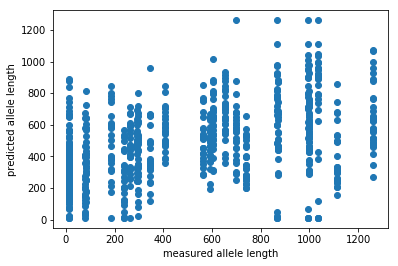

In [223]:
example_workflow(name="nakamori", simulation_step=simulation_step_LASSO, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=1)

In nakamori, muscle, using simulation_step_LinearRegression r² is 0.18180459862372564, which corrsponds to p-value 0.027614000000000027


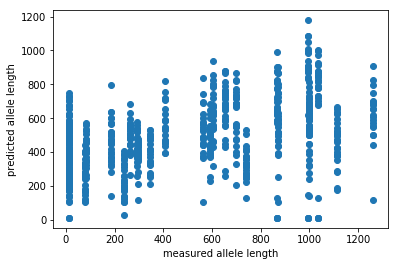

In [224]:
example_workflow(name="nakamori", simulation_step=simulation_step_LinearRegression, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=None)

[1035, 186, 604, 1000, 345, 1111, 12, 83, 408, 77, 240, 654, 561, 12, 12, 408, 1111, 866, 740, 77, 345, 290, 872, 1261, 12, 1000, 993, 561, 697, 345, 12, 740, 290, 604, 240, 12, 1000, 83, 11, 999, 261, 866, 1261, 999, 11, 993, 345, 83, 1035, 77, 290, 1111, 12, 186, 593, 12, 11, 83, 290, 297, 872, 408, 593, 12, 1035, 993, 1111, 240, 561, 654, 999, 83, 1035, 240, 297, 77, 993, 186, 261, 345, 12, 290, 866, 604, 12, 77, 12, 604, 999, 12, 345, 83, 1261, 697, 872, 11, 1035, 1000, 261, 697, 11, 1111, 12, 654, 872, 1000, 297, 604, 77, 593, 740, 240, 593, 866, 604, 83, 999, 1035, 1000, 77, 1111, 561, 290, 740, 345, 12, 561, 654, 12, 408, 1261, 77, 345, 697, 297, 11, 593, 290, 1000, 240, 654, 408, 593, 1261, 12, 604, 872, 186, 993, 83, 1035, 561, 740, 11, 604, 12, 83, 290, 1035, 1111, 12, 297, 561, 872, 1261, 993, 408, 11, 11, 186, 993, 1111, 240, 77, 654, 12, 604, 12, 872, 290, 866, 740, 697, 1000, 77, 561, 999, 1035, 654, 186, 740, 11, 240, 345, 83, 12, 345, 1000, 12, 604, 83, 11, 408, 872, 10

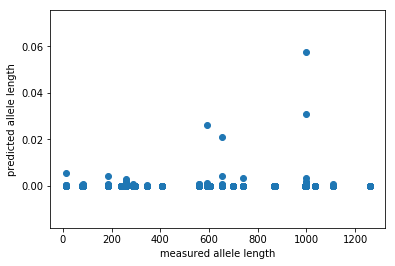

In [242]:
example_workflow(name="nakamori", simulation_step=simulation_step_GaussianProcess, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=None)

In nakamori, muscle, using simulation_step_PLSR r² is 0.1650698141497103, which corrsponds to p-value 0.03649100000000005


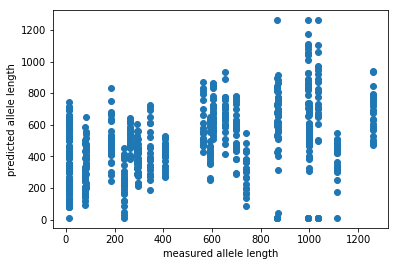

In [229]:
example_workflow(name="nakamori", simulation_step=simulation_step_PLSR, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=2)

In nakamori, muscle, using simulation_step_RandomForestRegressor r² is 0.08836142770440113, which corrsponds to p-value 0.132015


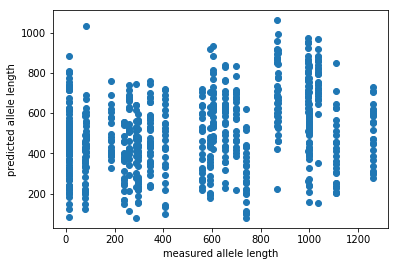

In [230]:
example_workflow(name="nakamori", simulation_step=simulation_step_RandomForestRegressor, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=None)

In [231]:
#import time
#start = time.time()
#if not in_ipynb():
#    example_workflow(name=gene_arg, simulation_step=simulation_step_LASSO, tissue=tissue_arg, simulation_runs=simulation_arg, select_top_k_genes=top_genes_arg, PLSR_dimensions=PLSR_arg)
#else:
#    example_workflow(name="nakamori", simulation_step=simulation_step_LASSO, tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=2)
#stop = time.time()
#print("took {} seconds".format(stop - start))